In [12]:
import catboost
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import time
import xgboost as xgb

from catboost import Pool, CatBoostRegressor, CatBoostClassifier, cv
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.pylab import rcParams
from mlxtend.preprocessing import DenseTransformer

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer, LabelEncoder


# matplotlib settings
matplotlib.style.use('ggplot')
rcParams['figure.figsize'] = 12, 8
rcParams['font.size'] = 12
rcParams['axes.facecolor'] = 'white'

In [13]:
# ! pip install jupyternotify
%load_ext jupyternotify

The jupyternotify extension is already loaded. To reload it, use:
  %reload_ext jupyternotify


In [14]:
n_time = 3
n_folds = 518

In [62]:
def plot_top_features(model, feature_names, num):
    top = sorted(zip(feature_names, model.feature_importances_),
                  key = lambda x: x[1], reverse = True)[:num]
    top = sorted(top, key = lambda x: x[1])
    plot_top = zip(*top)
    plt.figure()
    plt.barh(range(0, len(plot_top[0])), plot_top[1], tick_label = plot_top[0])
    plt.title('Feature importance')
    plt.show()
    return top

In [ ]:
print ("number of training instances = {0}".format(df_train.shape[0]))
print ("number of features = {0}".format(df_train.shape[1]))
print ("number of categorical features = {0}".format(len(cat_indices)))

# Data Loading

In [39]:
df_train = pd.read_csv('../data/housing_usa/train.csv')
df_train.head(2)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500


In [40]:
y_train = np.log1p(df_train['SalePrice'])
df_train = df_train.drop('SalePrice', axis = 1)

In [41]:
cat_features = list(df_train.select_dtypes(include=['object']).columns.values)
cat_indices = [df_train.columns.get_loc(name) for name in cat_features]

df_train[cat_features] = df_train[cat_features].astype(str)

In [42]:
pool_train = Pool(df_train, label = y_train, cat_features=cat_indices)

## Exploratory Data Analysis
### Data statistics

In [96]:
print ("number of training instances = {0}".format(df_train.shape[0]))
print ("number of features = {0}".format(df_train.shape[1]))
print ("number of categorical features = {0}".format(len(cat_indices)))

number of training instances = 1460
number of features = 80
number of categorical features = 43


#### Price distribution (log scale)

In [98]:
print("mean = {0}, std_dev = {1}".format(np.mean(y_train), np.std(y_train)))

mean = 12.0240573949, std_dev = 0.399312452194


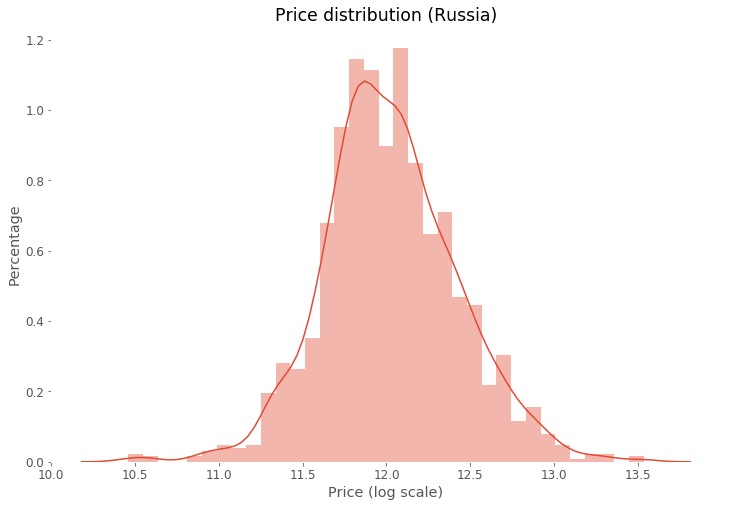

In [97]:
sns.distplot(y_train, norm_hist=True)
plt.xlabel('Price (log scale)')
plt.ylabel('Percentage')
plt.title('Price distribution (Russia)')
plt.show()

# CatBoost

In [54]:
%%notify
model = CatBoostRegressor(loss_function = 'RMSE', custom_metric = 'RMSE',  calc_feature_importance = True)

cv_params = model.get_params()
cv_params['logging_level'] = 'Silent'
del cv_params['calc_feature_importance']

av_time = 0
for i in range(0, n_time):
    t = time.time()
    cv_data = cv(cv_params, pool_train, fold_count=n_folds, shuffle = True)
    av_time += time.time() - t

<IPython.core.display.Javascript object>

In [ ]:
model.fit(pool_train, logging_level='Silent')

In [55]:
print('average cv time (CatBoost) = {0:.2f}'.format(av_time / n_time))
print('RMSLE (CatBoost) = {0}'.format(cv_data['RMSE_test_avg'][-1])) 

average cv time (CatBoost) = 295.17
RMSLE (CatBoost) = 0.171622163189


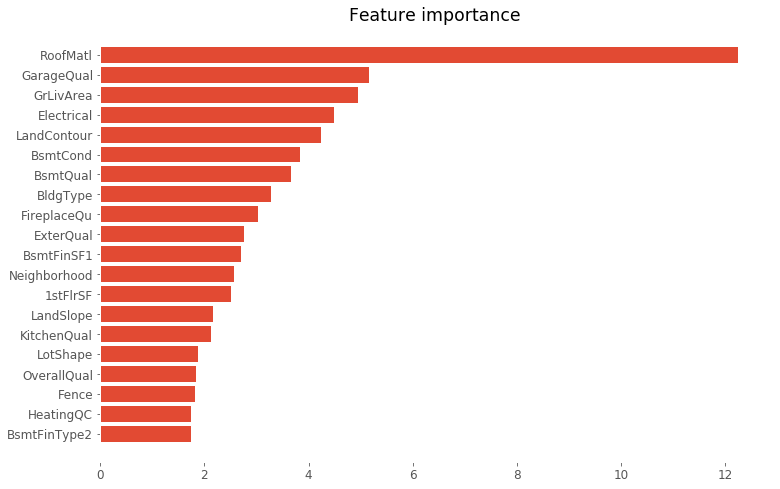

In [63]:
top_features = plot_top_features(model, pool_train.get_feature_names(), 20)

# XGBoost

In [45]:
df_train_dummy = pd.get_dummies(df_train, columns = cat_features)

In [46]:
xgboost_clf = Pipeline([('to_dense', DenseTransformer()), 
                        ('clf', xgb.XGBRegressor(eval_metric = 'rmse'))])

In [47]:
av_time = 0
for i in range(0, n_time):
    t = time.time()
    xgboost_cv = cross_val_score(xgboost_clf, df_train_dummy, y_train, 
                             scoring='neg_mean_squared_error', cv=n_folds, n_jobs = -1, verbose=False)
    av_time += time.time() - t

In [66]:
_ = xgboost_clf.fit(df_train_dummy, y_train)

In [48]:
print('average cv time (XGBoost) = {0:.2f} sec'.format(av_time / n_time))
print('RMSLE (XGBoost) = {0}'.format(np.sqrt(-xgboost_cv.mean())))

average cv time (XGBoost) = 3.08 sec
RMSLE (XGBoost) = 0.131508102578


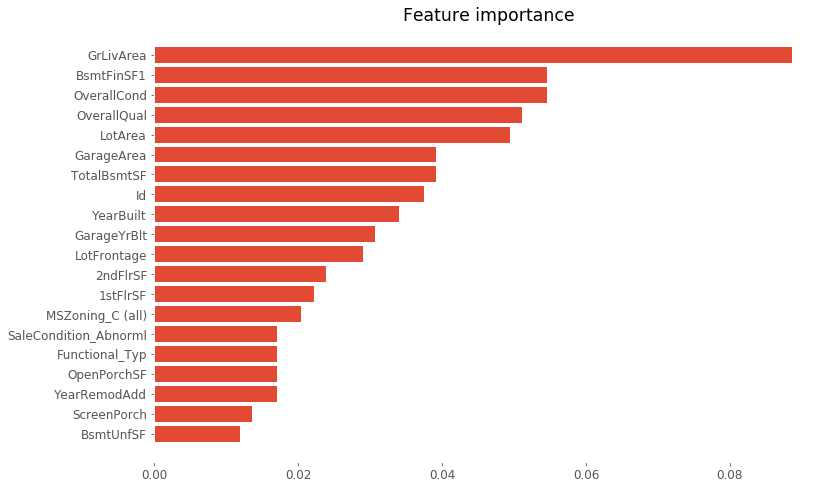

In [95]:
_ = plot_top_features(xgboost_clf.named_steps['clf'], df_train_dummy.columns.values, 20)

# GradientBoostingRegressor

In [87]:
sk_boost_clf = Pipeline([('replace_nan', Imputer()),
                        ('to_dense', DenseTransformer()), 
                        ('clf', GradientBoostingRegressor())])

In [88]:
_ = sk_boost_clf.fit(df_train_dummy, y_train)

In [89]:
av_time = 0
for i in range(0, n_time):
    t = time.time()
    sklearn_cv = cross_val_score(sk_boost_clf, df_train_dummy, y_train, 
                     scoring='neg_mean_squared_error', cv=n_folds, n_jobs = -1, verbose=False)
    av_time += time.time() - t

In [90]:
print('average cv time (GradientBoostingRegressor) = {0:.2f} sec'.format(av_time / n_time))
print('RMSLE (GradientBoostingRegressor) = {0}'.format(np.sqrt(-sklearn_cv.mean())))

average cv time (GradientBoostingRegressor) = 6.07 sec
RMSLE (GradientBoostingRegressor) = 0.128484446205


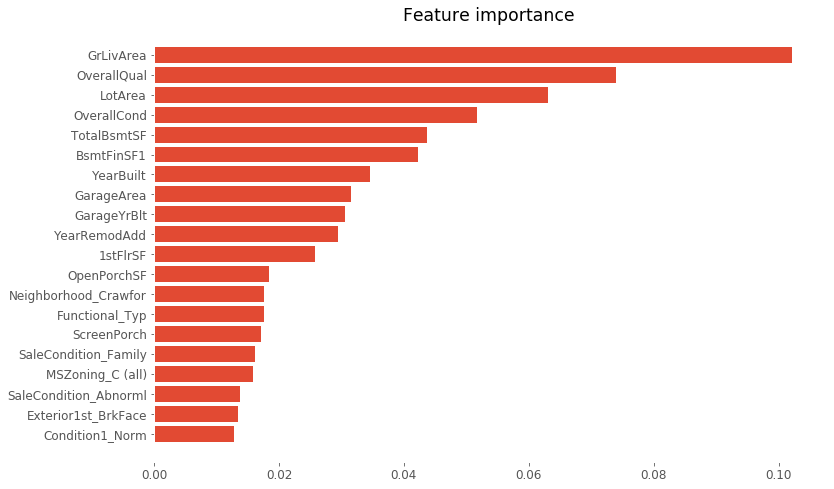

In [94]:
_ = plot_top_features(sk_boost_clf.named_steps['clf'], df_train_dummy.columns.values, 20)